In [5]:
import numpy as np
import pandas as pd
from pandas import Series, DataFrame

from scipy.stats import pearsonr

import matplotlib.pyplot as plt
import seaborn as sns


%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 8)
sns.set_style('white')

In [6]:
pd.get_option('display.max_columns')

20

In [7]:
train_df = pd.read_csv('./data/application_train.csv.zip')
train_df = train_df.rename(lambda x: x.lower(), axis=1)
train_df.head()

,sk_id_curr,target,name_contract_type,code_gender,flag_own_car,flag_own_realty,cnt_children,amt_income_total,amt_credit,amt_annuity,...,flag_document_18,flag_document_19,flag_document_20,flag_document_21,amt_req_credit_bureau_hour,amt_req_credit_bureau_day,amt_req_credit_bureau_week,amt_req_credit_bureau_mon,amt_req_credit_bureau_qrt,amt_req_credit_bureau_year
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [8]:
target_column = 'target'

In [9]:
X_train = train_df.drop([target_column], axis=1)
y_train = train_df[target_column].copy()
X_train.shape, y_train.shape

((307511, 121), (307511,))

### Common training data statistics

In [10]:
X_train.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Data columns (total 121 columns):
sk_id_curr                      int64
name_contract_type              object
code_gender                     object
flag_own_car                    object
flag_own_realty                 object
cnt_children                    int64
amt_income_total                float64
amt_credit                      float64
amt_annuity                     float64
amt_goods_price                 float64
name_type_suite                 object
name_income_type                object
name_education_type             object
name_family_status              object
name_housing_type               object
region_population_relative      float64
days_birth                      int64
days_employed                   int64
days_registration               float64
days_id_publish                 int64
own_car_age                     float64
flag_mobil                      int64
flag_emp_phone               

In [11]:
y_train.describe()

count    307511.000000
mean          0.080729
std           0.272419
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           1.000000
Name: target, dtype: float64

### Missing data

In [12]:
X_train.isnull().sum() / len(X_train)

sk_id_curr                    0.000000
name_contract_type            0.000000
code_gender                   0.000000
flag_own_car                  0.000000
flag_own_realty               0.000000
cnt_children                  0.000000
amt_income_total              0.000000
amt_credit                    0.000000
amt_annuity                   0.000039
amt_goods_price               0.000904
name_type_suite               0.004201
name_income_type              0.000000
name_education_type           0.000000
name_family_status            0.000000
name_housing_type             0.000000
region_population_relative    0.000000
days_birth                    0.000000
days_employed                 0.000000
days_registration             0.000000
days_id_publish               0.000000
own_car_age                   0.659908
flag_mobil                    0.000000
flag_emp_phone                0.000000
flag_work_phone               0.000000
flag_cont_mobile              0.000000
flag_phone               

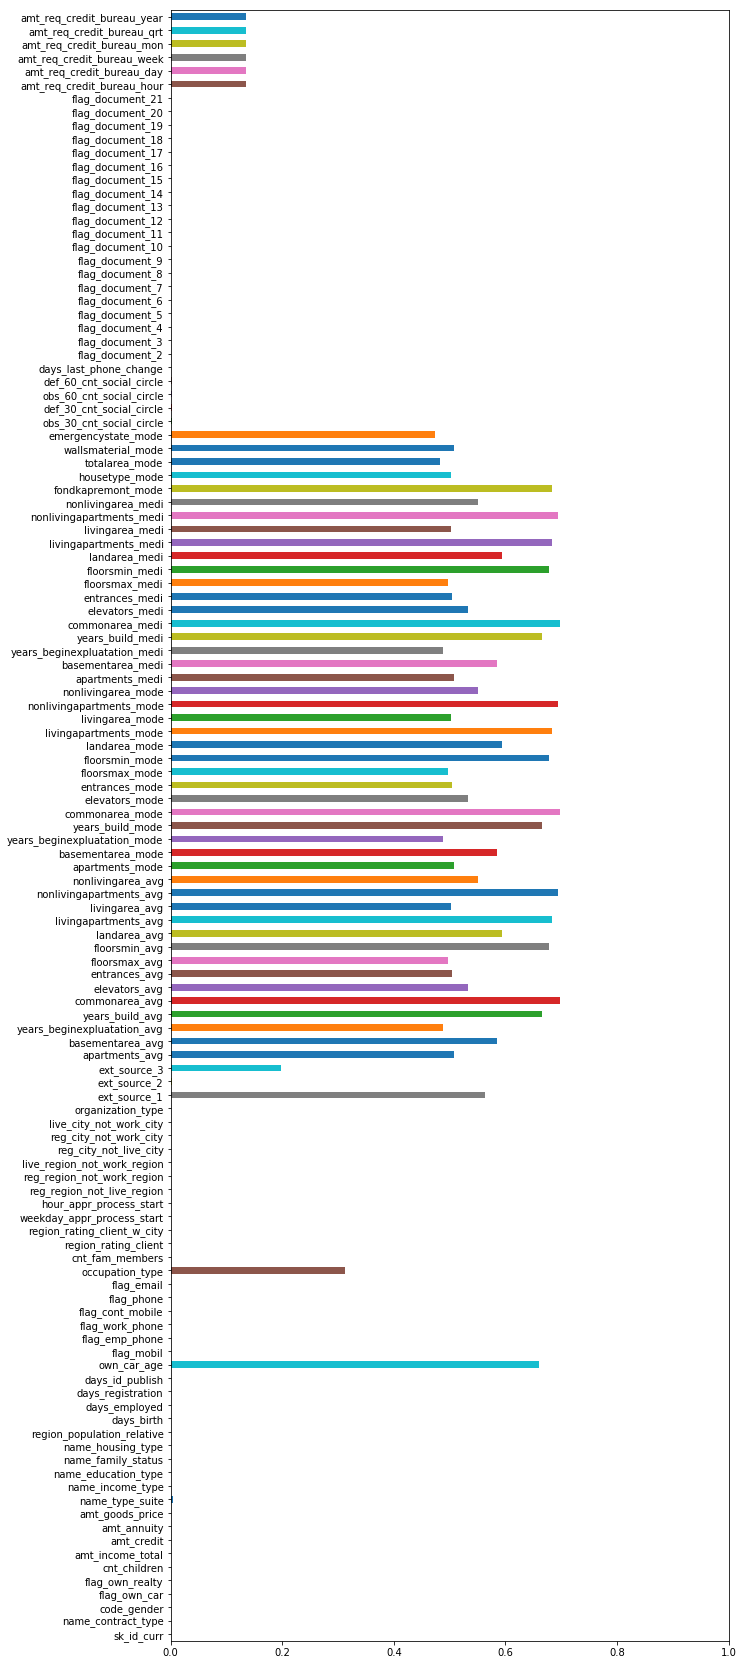

In [208]:
(X_train.isnull().sum() / len(X_train)).plot(kind='barh', figsize=(10, 30), xlim=[0, 1])

### target column

In [8]:
train_df[target_column].value_counts()

0    282686
1     24825
Name: target, dtype: int64

In [9]:
y_train_count = train_df[target_column].value_counts()[1]
y_train_count

24825

### Stratified sampling (TODO - add random seed)

In [10]:
def get_equal_classes(df, target_column, sample_size, random_state):
    sample_df = (train_df.groupby(target_column, as_index=False)
                         .apply(lambda x: x.sample(sample_size, random_state=random_state)))
    return sample_df

In [11]:
sample_size = 1000
random_state = 42

sample_df = get_equal_classes(train_df, target_column, sample_size, random_state)
sample_df.groupby(target_column)[target_column].count()

target
0    1000
1    1000
Name: target, dtype: int64

In [48]:
X_train_sample = sample_df.drop([target_column], axis=1)
y_train_sample = sample_df[target_column].copy()

## Numeric features

### id column

In [12]:
id_column = 'sk_id_curr'

In [13]:
train_df[[id_column]].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Data columns (total 1 columns):
sk_id_curr    307511 non-null int64
dtypes: int64(1)
memory usage: 2.3 MB


In [14]:
train_df[id_column].describe()

count    307511.000000
mean     278180.518577
std      102790.175348
min      100002.000000
25%      189145.500000
50%      278202.000000
75%      367142.500000
max      456255.000000
Name: sk_id_curr, dtype: float64

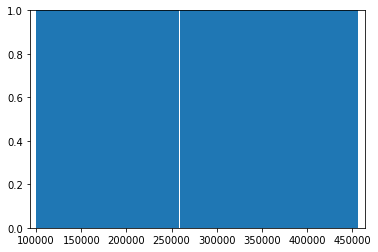

In [15]:
sns.rugplot(sample_df[id_column], height=1)

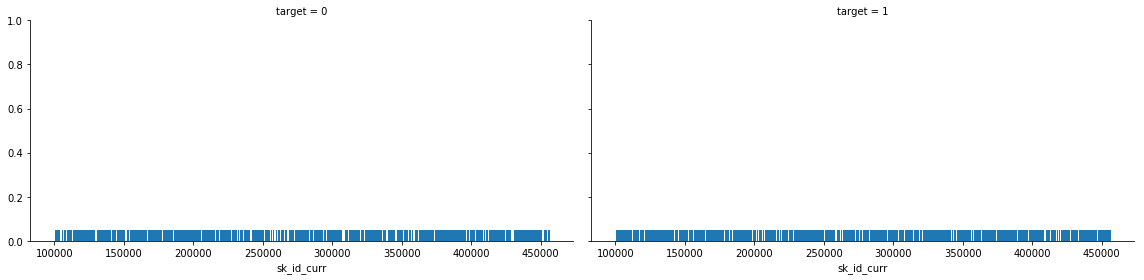

In [16]:
g = sns.FacetGrid(sample_df, col=target_column, size=4, aspect=2)
g.map(sns.rugplot, id_column)

### child count column

In [17]:
child_cnt_column = 'cnt_children'

In [18]:
train_df[[child_cnt_column]].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Data columns (total 1 columns):
cnt_children    307511 non-null int64
dtypes: int64(1)
memory usage: 2.3 MB


In [19]:
train_df[[child_cnt_column]].describe()

,cnt_children
count,307511.000000
mean,0.417052
std,0.722121
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,19.000000


In [20]:
train_df[child_cnt_column].value_counts().sort_index()

0     215371
1      61119
2      26749
3       3717
4        429
5         84
6         21
7          7
8          2
9          2
10         2
11         1
12         2
14         3
19         2
Name: cnt_children, dtype: int64

In [21]:
pearsonr(train_df[child_cnt_column], train_df[target_column])

(0.019187133596270035, 1.9224915500910093e-26)

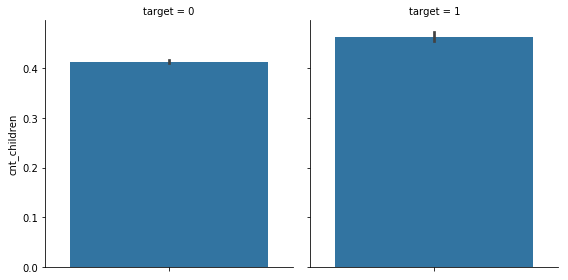

In [22]:
sns.factorplot(y=child_cnt_column, col=target_column, data=train_df, kind='bar')
plt.show()

### amt columns

In [23]:
amt_columns = ['amt_income_total', 'amt_credit', 'amt_annuity', 'amt_goods_price']

In [24]:
train_df[amt_columns].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Data columns (total 4 columns):
amt_income_total    307511 non-null float64
amt_credit          307511 non-null float64
amt_annuity         307499 non-null float64
amt_goods_price     307233 non-null float64
dtypes: float64(4)
memory usage: 9.4 MB


In [25]:
train_df[amt_columns].describe()

,amt_income_total,amt_credit,amt_annuity,amt_goods_price
count,3.075110e+05,3.075110e+05,307499.000000,3.072330e+05
mean,1.687979e+05,5.990260e+05,27108.573909,5.383962e+05
std,2.371231e+05,4.024908e+05,14493.737315,3.694465e+05
min,2.565000e+04,4.500000e+04,1615.500000,4.050000e+04
25%,1.125000e+05,2.700000e+05,16524.000000,2.385000e+05
50%,1.471500e+05,5.135310e+05,24903.000000,4.500000e+05
75%,2.025000e+05,8.086500e+05,34596.000000,6.795000e+05
max,1.170000e+08,4.050000e+06,258025.500000,4.050000e+06


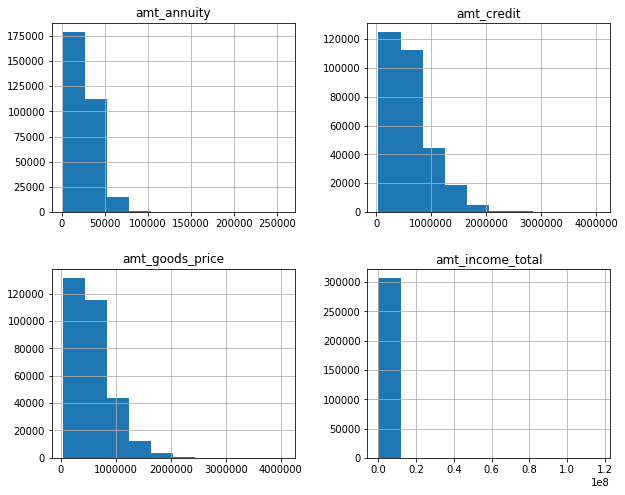

In [61]:
train_df[amt_columns].hist()
plt.show()

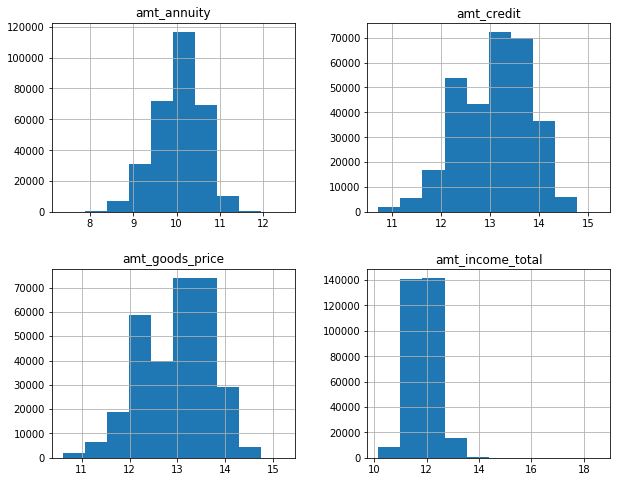

In [62]:
train_df[amt_columns].apply(np.log).hist()
plt.show()

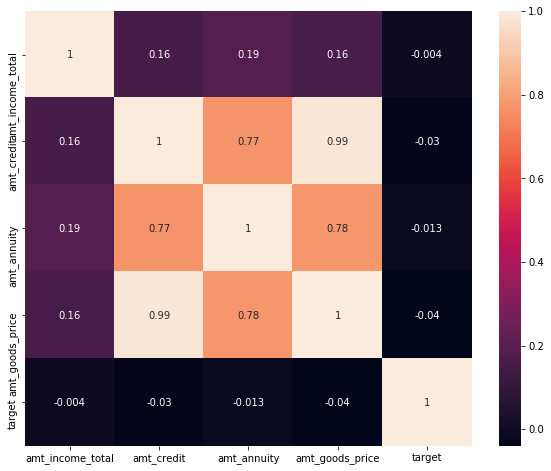

In [63]:
sns.heatmap(train_df[amt_columns + [target_column]].corr(), annot=True)
plt.show()

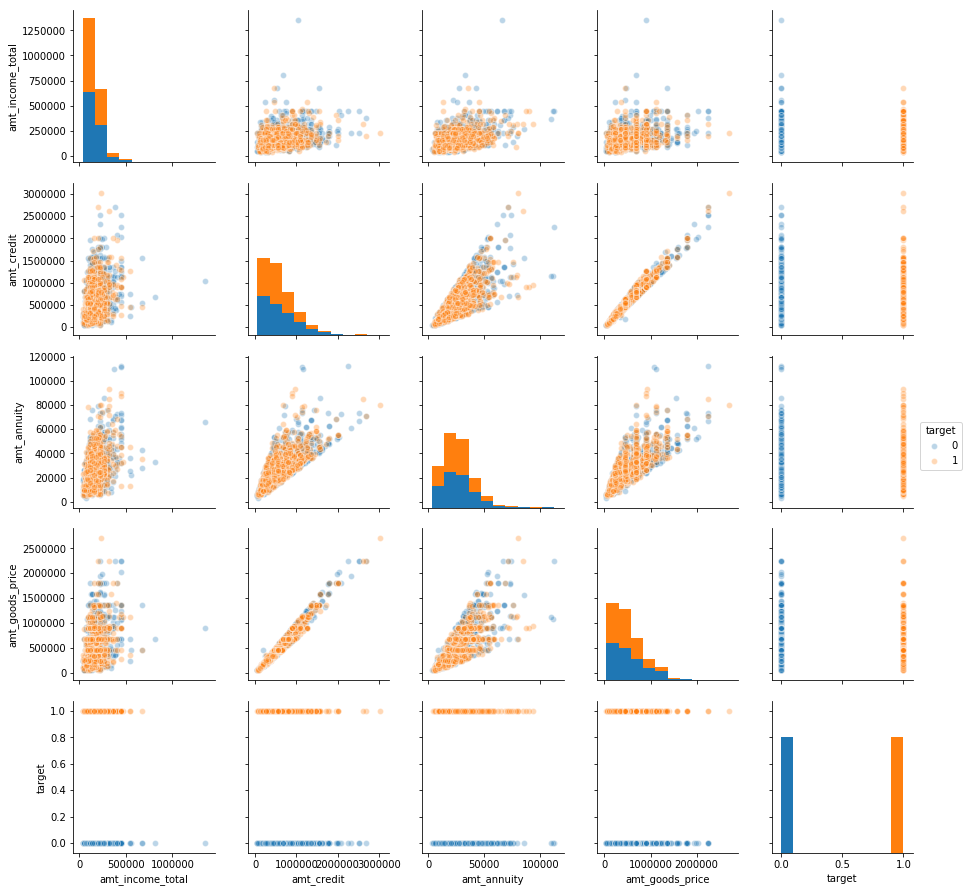

In [29]:
sns.pairplot(sample_df[amt_columns + [target_column]], hue=target_column,
             plot_kws={'alpha': 0.3})
plt.show()

/home/dlabazkin/miniconda3/envs/otus/lib/python3.6/site-packages/matplotlib/contour.py:960: UserWarning: The following kwargs were not used by contour: 'label', 'color'
  s)


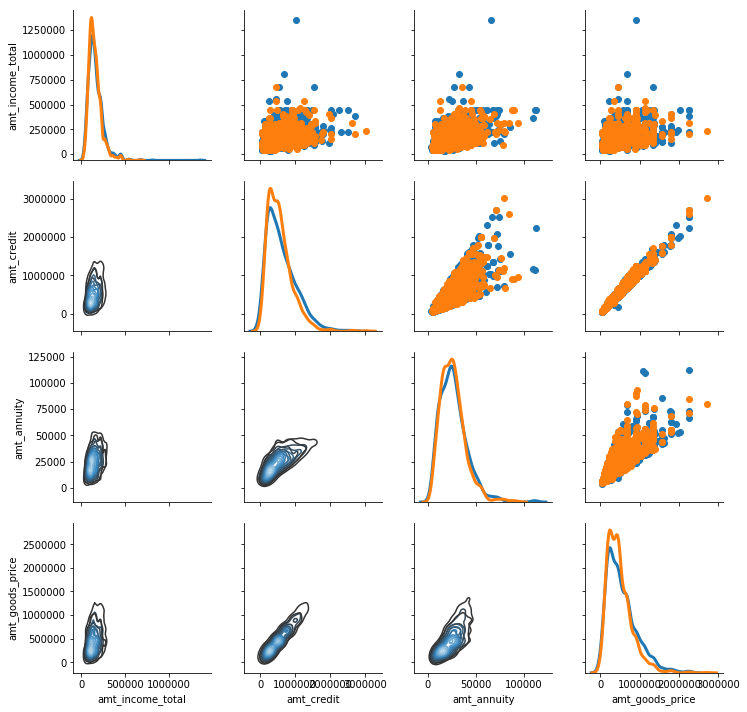

In [30]:
g = sns.PairGrid(sample_df[amt_columns + [target_column]], vars=amt_columns,
                 hue=target_column, diag_sharey=False)
g.map_lower(sns.kdeplot, cmap="Blues_d")
g.map_upper(plt.scatter)
g.map_diag(sns.kdeplot, lw=3)

### region population column

In [31]:
reg_pop_column = 'region_population_relative'

In [32]:
train_df[[reg_pop_column]].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Data columns (total 1 columns):
region_population_relative    307511 non-null float64
dtypes: float64(1)
memory usage: 2.3 MB


In [33]:
train_df[[reg_pop_column]].describe()

,region_population_relative
count,307511.000000
mean,0.020868
std,0.013831
min,0.000290
25%,0.010006
50%,0.018850
75%,0.028663
max,0.072508


/home/dlabazkin/miniconda3/envs/otus/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


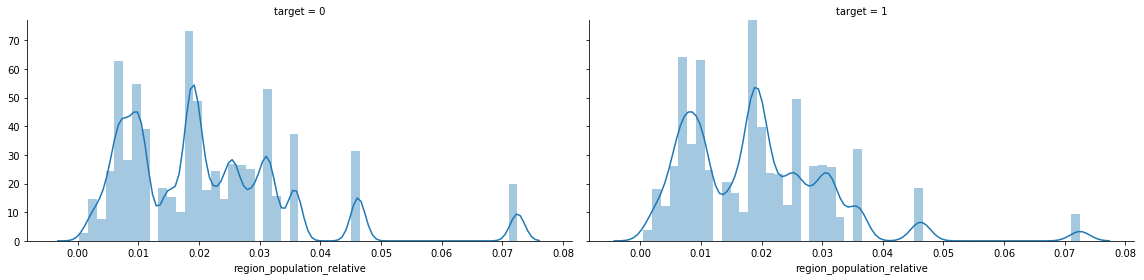

In [64]:
g = sns.FacetGrid(train_df, col=target_column, size=4, aspect=2)
g.map(sns.distplot, reg_pop_column)
#sns.distplot(train_df[[reg_pop_column]])

In [35]:
pearsonr(train_df[reg_pop_column], train_df[target_column])

(-0.037227148542445229, 9.5827015645530643e-95)

### days columns

In [36]:
days_columns = ['days_birth', 'days_employed', 'days_registration', 'days_id_publish']

In [37]:
train_df[days_columns].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Data columns (total 4 columns):
days_birth           307511 non-null int64
days_employed        307511 non-null int64
days_registration    307511 non-null float64
days_id_publish      307511 non-null int64
dtypes: float64(1), int64(3)
memory usage: 9.4 MB


In [38]:
train_df[days_columns].describe()

,days_birth,days_employed,days_registration,days_id_publish
count,307511.000000,307511.000000,307511.000000,307511.000000
mean,-16036.995067,63815.045904,-4986.120328,-2994.202373
std,4363.988632,141275.766519,3522.886321,1509.450419
min,-25229.000000,-17912.000000,-24672.000000,-7197.000000
25%,-19682.000000,-2760.000000,-7479.500000,-4299.000000
50%,-15750.000000,-1213.000000,-4504.000000,-3254.000000
75%,-12413.000000,-289.000000,-2010.000000,-1720.000000
max,-7489.000000,365243.000000,0.000000,0.000000


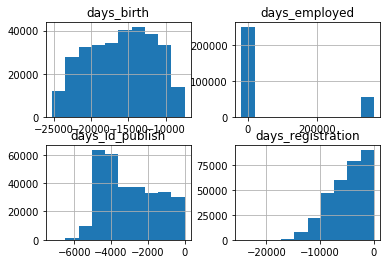

In [39]:
train_df[days_columns].hist()
plt.show()

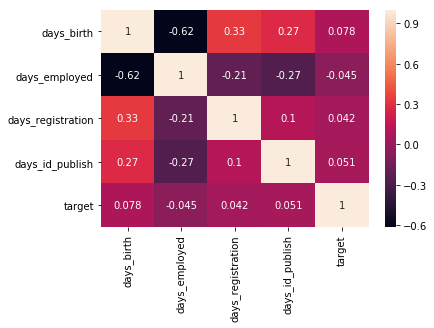

In [40]:
sns.heatmap(train_df[days_columns + [target_column]].corr(), annot=True)
plt.show()

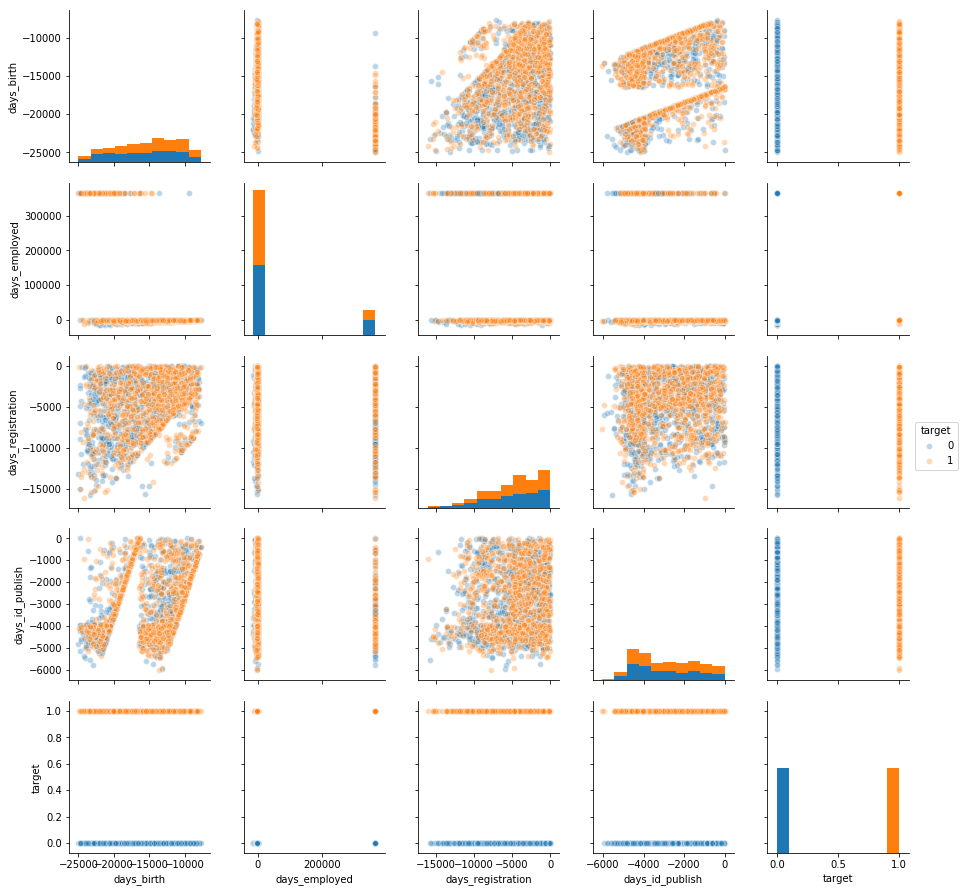

In [41]:
sns.pairplot(sample_df[days_columns + [target_column]], hue=target_column,
             plot_kws={'alpha': 0.3})
plt.show()

/home/dlabazkin/miniconda3/envs/otus/lib/python3.6/site-packages/matplotlib/contour.py:960: UserWarning: The following kwargs were not used by contour: 'label', 'color'
  s)


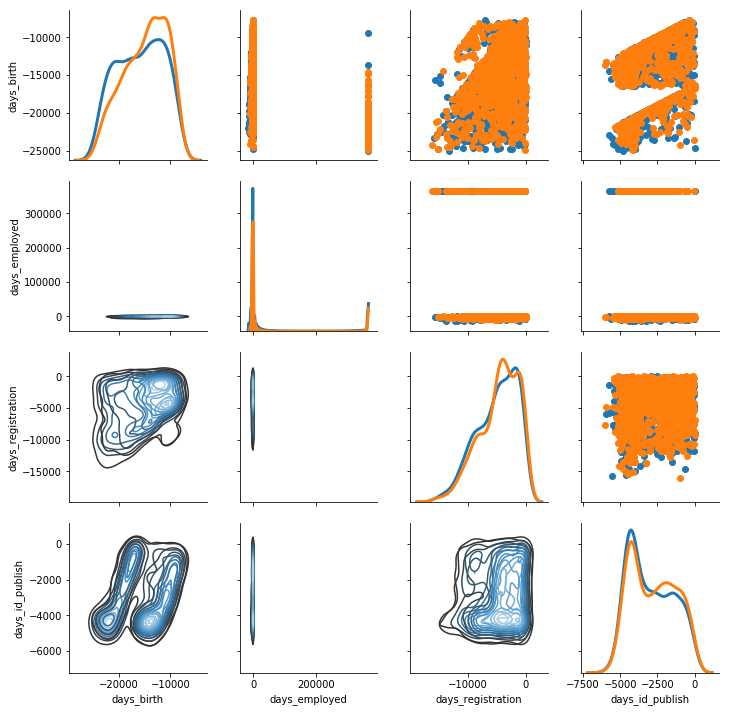

In [42]:
g = sns.PairGrid(sample_df[days_columns + [target_column]], vars=days_columns,
                 hue=target_column, diag_sharey=False)
g.map_lower(sns.kdeplot, cmap="Blues_d")
g.map_upper(plt.scatter)
g.map_diag(sns.kdeplot, lw=3)
g.set(alpha=0.3)

/home/dlabazkin/miniconda3/envs/otus/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


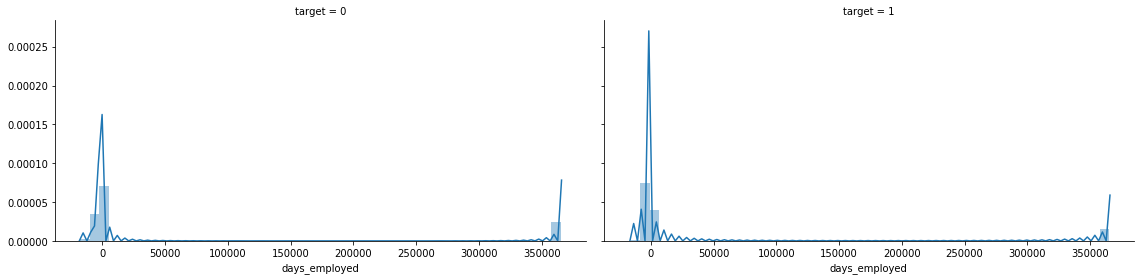

In [67]:
g = sns.FacetGrid(train_df, col='target', size=4, aspect=2)
g.map(sns.distplot, 'days_employed')

### Car age

In [244]:
car_age_column = 'own_car_age'

In [223]:
train_df[[car_age_column]].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Data columns (total 1 columns):
own_car_age    104582 non-null float64
dtypes: float64(1)
memory usage: 2.3 MB


In [224]:
train_df[[car_age_column]].describe()

,own_car_age
count,104582.000000
mean,12.061091
std,11.944812
min,0.000000
25%,5.000000
50%,9.000000
75%,15.000000
max,91.000000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f7614079160>]], dtype=object)

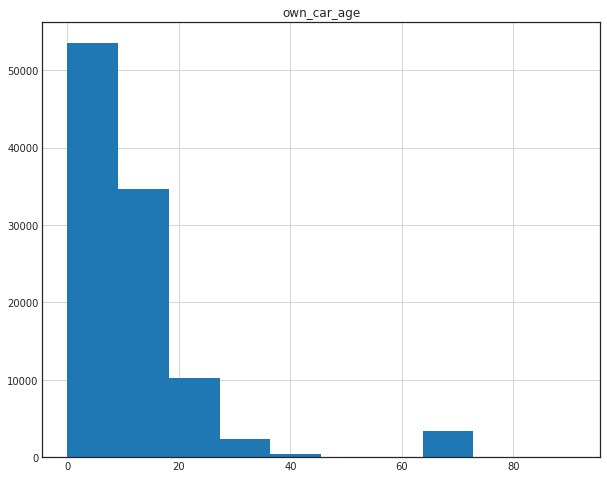

In [235]:
train_df[[car_age_column]].hist()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f760fd325f8>]], dtype=object)

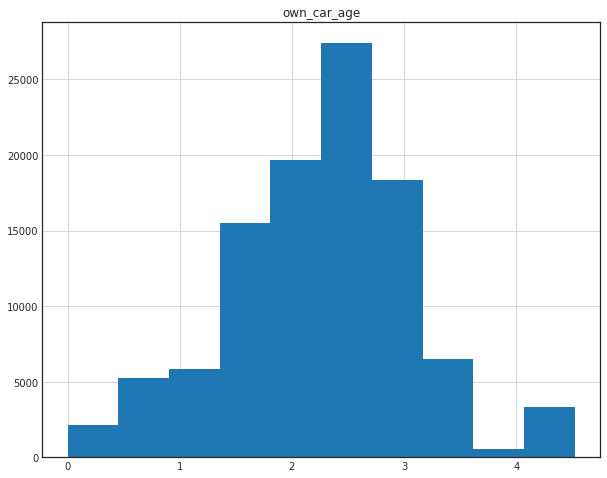

In [236]:
train_df[[car_age_column]].apply(lambda x: np.log(x+1)).hist()

In [256]:
train_df.loc[train_df[car_age_column] > 60, target_column].value_counts(normalize=True)

0    0.916143
1    0.083857
Name: target, dtype: float64

In [ ]:
num_columns = [child_cnt_column] + amt_columns + [reg_pop_column] + days_columns + car_age_column
num_columns

## Categorical Features

### Contract type

In [75]:
contract_column = 'name_contract_type'

In [76]:
train_df[[contract_column]].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Data columns (total 1 columns):
name_contract_type    307511 non-null object
dtypes: object(1)
memory usage: 2.3+ MB


In [77]:
train_df[[contract_column]].describe()

,name_contract_type
count,307511
unique,2
top,Cash loans
freq,278232


In [85]:
train_df[contract_column].value_counts()

Cash loans         278232
Revolving loans     29279
Name: name_contract_type, dtype: int64

In [117]:
cat_contract = train_df[contract_column].astype('category').cat.codes
pearsonr(cat_contract, train_df[target_column])

(-0.030895908161048057, 7.8687653362887092e-66)

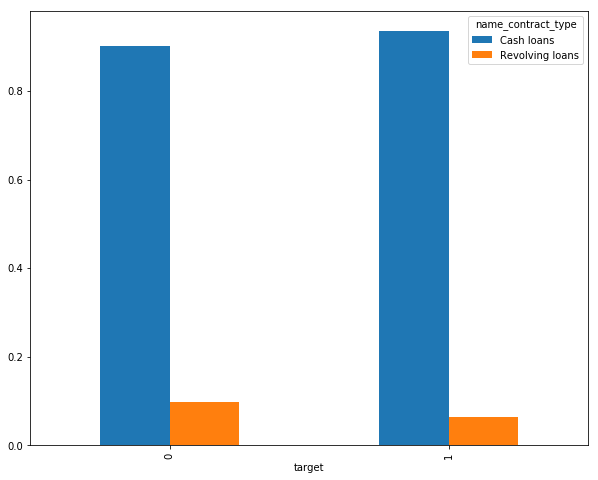

In [157]:
pd.crosstab(train_df[target_column], train_df[contract_column]).apply(lambda x: x / x.sum(), axis=1).plot.bar()

### Client gender

In [102]:
gender_column = 'code_gender'

In [103]:
train_df[[gender_column]].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Data columns (total 1 columns):
code_gender    307511 non-null object
dtypes: object(1)
memory usage: 2.3+ MB


In [104]:
train_df[[gender_column]].describe()

,code_gender
count,307511
unique,3
top,F
freq,202448


In [106]:
train_df[gender_column].unique()

array(['M', 'F', 'XNA'], dtype=object)

In [107]:
train_df[gender_column].value_counts()

F      202448
M      105059
XNA         4
Name: code_gender, dtype: int64

In [111]:
cat_gender = train_df[gender_column].astype('category').cat.codes
pearsonr(cat_gender, train_df[target_column])

(0.054692261855634527, 2.4032745617279243e-202)

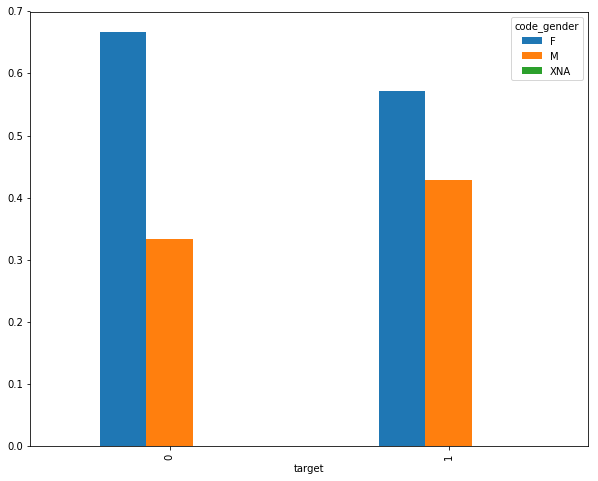

In [158]:
pd.crosstab(train_df[target_column], train_df[gender_column]).apply(lambda x: x / x.sum(), axis=1).plot.bar()

### flag_own columns

In [161]:
flag_own_columns = ['flag_own_car', 'flag_own_realty']

In [162]:
train_df[flag_own_columns].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Data columns (total 2 columns):
flag_own_car       307511 non-null object
flag_own_realty    307511 non-null object
dtypes: object(2)
memory usage: 4.7+ MB


In [163]:
train_df[flag_own_columns].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Data columns (total 2 columns):
flag_own_car       307511 non-null object
flag_own_realty    307511 non-null object
dtypes: object(2)
memory usage: 4.7+ MB


In [164]:
train_df[flag_own_columns].apply(Series.value_counts)

,flag_own_car,flag_own_realty
N,202924,94199
Y,104587,213312


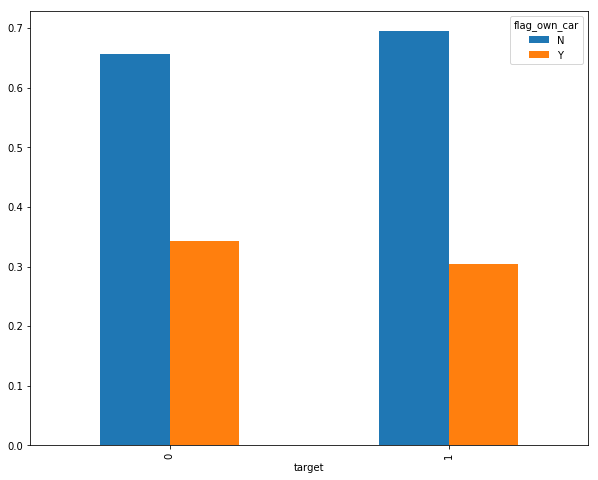

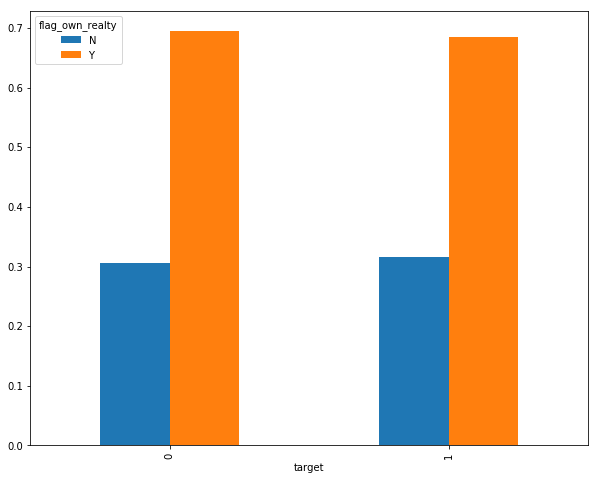

In [173]:
for col in flag_own_columns:
    pd.crosstab(train_df[target_column], train_df[col]).apply(lambda x: x / x.sum(), axis=1).plot.bar()

### name columns

In [174]:
name_columns = ['name_type_suite', 'name_income_type', 'name_education_type', 
                'name_family_status', 'name_housing_type']

In [176]:
train_df[name_columns].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Data columns (total 5 columns):
name_type_suite        306219 non-null object
name_income_type       307511 non-null object
name_education_type    307511 non-null object
name_family_status     307511 non-null object
name_housing_type      307511 non-null object
dtypes: object(5)
memory usage: 11.7+ MB


In [180]:
train_df[name_columns].describe()

,name_type_suite,name_income_type,name_education_type,name_family_status,name_housing_type
count,306219,307511,307511,307511,307511
unique,7,8,5,6,6
top,Unaccompanied,Working,Secondary / secondary special,Married,House / apartment
freq,248526,158774,218391,196432,272868


In [185]:
[(col, train_df[col].unique()) for col in name_columns]

[('name_type_suite',
  array(['Unaccompanied', 'Family', 'Spouse, partner', 'Children', 'Other_A',
         nan, 'Other_B', 'Group of people'], dtype=object)),
 ('name_income_type',
  array(['Working', 'State servant', 'Commercial associate', 'Pensioner',
         'Unemployed', 'Student', 'Businessman', 'Maternity leave'], dtype=object)),
 ('name_education_type',
  array(['Secondary / secondary special', 'Higher education',
         'Incomplete higher', 'Lower secondary', 'Academic degree'], dtype=object)),
 ('name_family_status',
  array(['Single / not married', 'Married', 'Civil marriage', 'Widow',
         'Separated', 'Unknown'], dtype=object)),
 ('name_housing_type',
  array(['House / apartment', 'Rented apartment', 'With parents',
         'Municipal apartment', 'Office apartment', 'Co-op apartment'], dtype=object))]

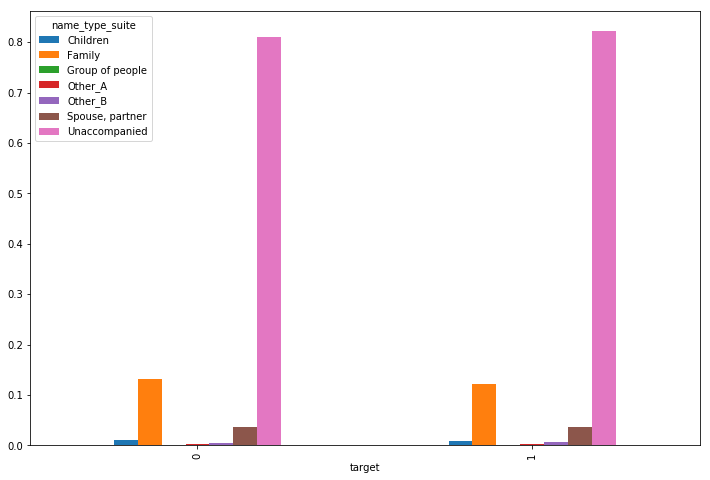

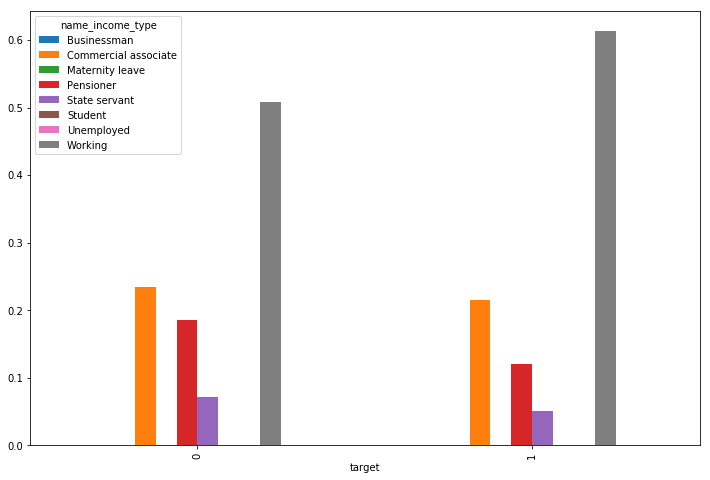

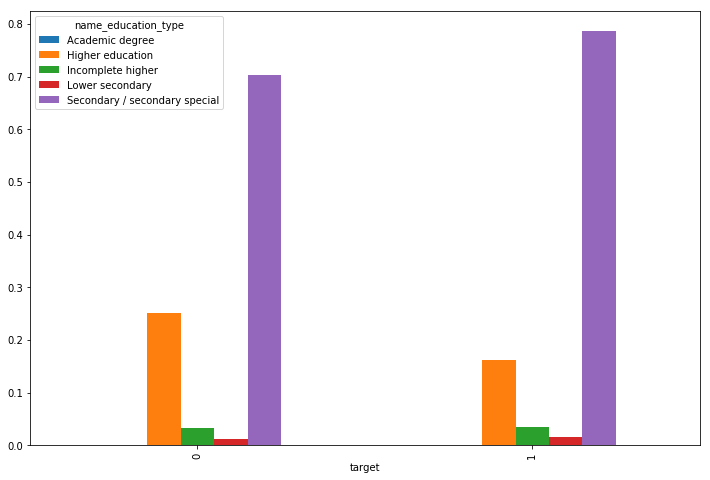

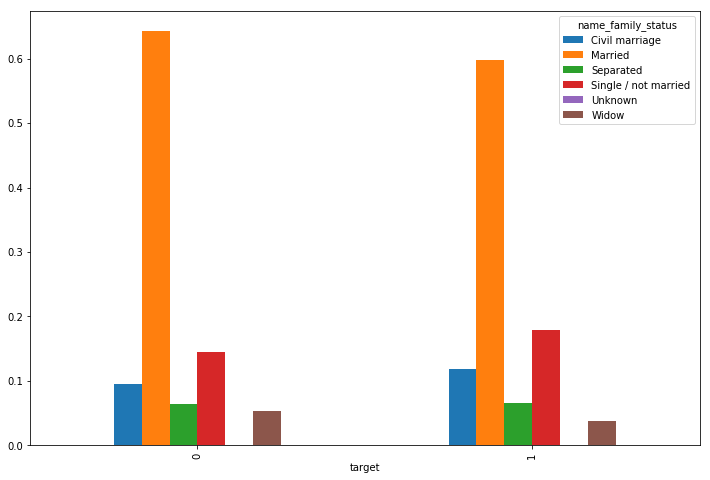

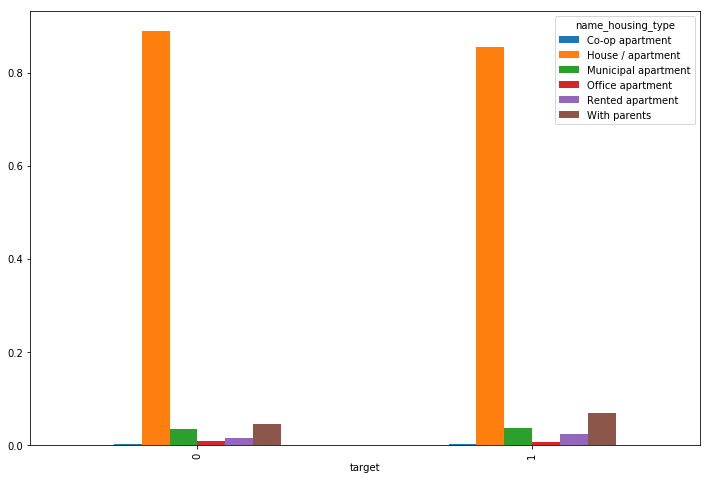

In [194]:
for col in name_columns:
    (pd.crosstab(train_df[target_column], train_df[col]).apply(lambda x: x / x.sum(), axis=1)
       .plot.bar(figsize=(12, 8)))

### flag columns

In [257]:
flag_columns = ['flag_mobil', 'flag_emp_phone', 'flag_work_phone', 'flag_cont_mobile',
                'flag_phone', 'flag_email']

In [258]:
train_df[flag_columns].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Data columns (total 6 columns):
flag_mobil          307511 non-null int64
flag_emp_phone      307511 non-null int64
flag_work_phone     307511 non-null int64
flag_cont_mobile    307511 non-null int64
flag_phone          307511 non-null int64
flag_email          307511 non-null int64
dtypes: int64(6)
memory usage: 14.1 MB


In [259]:
train_df[flag_columns].describe()

,flag_mobil,flag_emp_phone,flag_work_phone,flag_cont_mobile,flag_phone,flag_email
count,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000
mean,0.999997,0.819889,0.199368,0.998133,0.281066,0.056720
std,0.001803,0.384280,0.399526,0.043164,0.449521,0.231307
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000
50%,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000
75%,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [260]:
[(col, train_df[col].unique()) for col in flag_columns]

[('flag_mobil', array([1, 0])),
 ('flag_emp_phone', array([1, 0])),
 ('flag_work_phone', array([0, 1])),
 ('flag_cont_mobile', array([1, 0])),
 ('flag_phone', array([1, 0])),
 ('flag_email', array([0, 1]))]

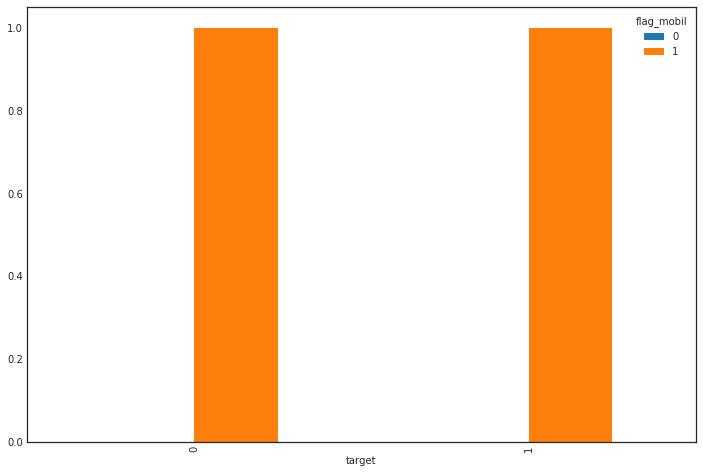

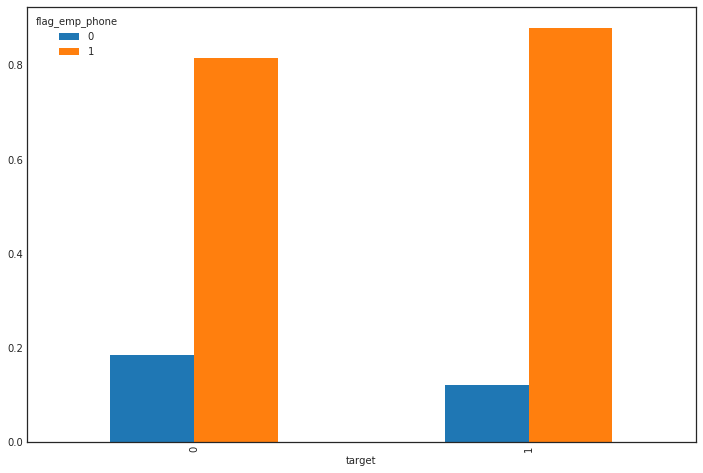

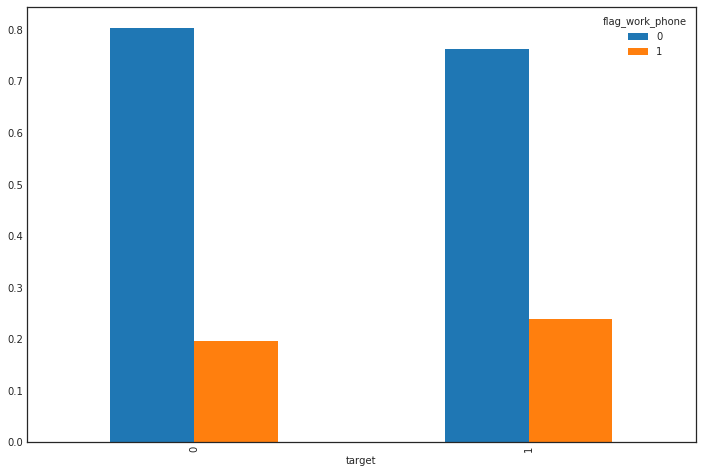

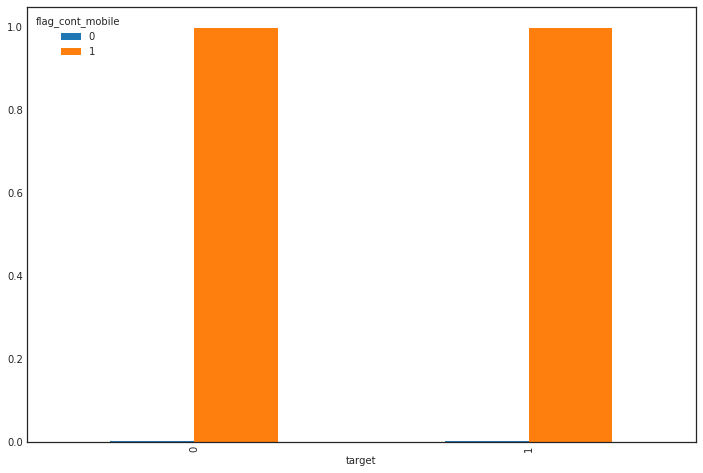

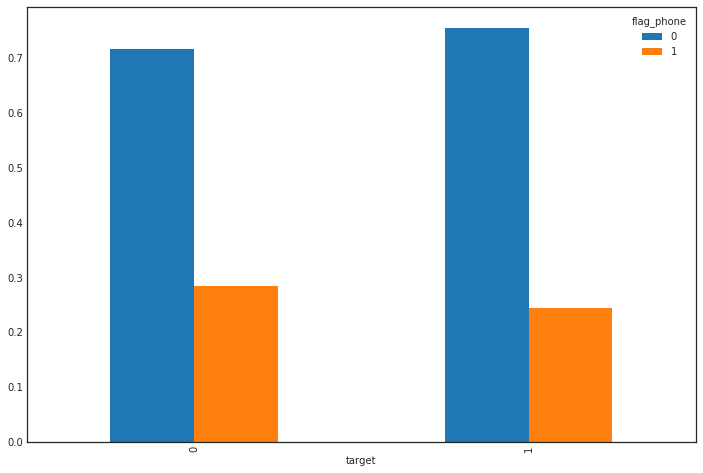

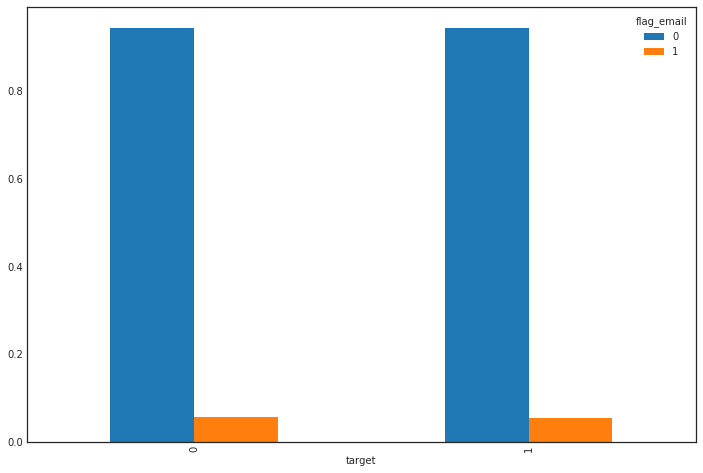

In [261]:
for col in flag_columns:
    (pd.crosstab(train_df[target_column], train_df[col]).apply(lambda x: x / x.sum(), axis=1)
       .plot.bar(figsize=(12, 8)))

In [262]:
cat_columns = [contract_column] + [gender_column] + flag_own_columns + name_columns + flag_columns
cat_columns

['name_contract_type',
 'code_gender',
 'flag_own_car',
 'flag_own_realty',
 'name_type_suite',
 'name_income_type',
 'name_education_type',
 'name_family_status',
 'name_housing_type',
 'flag_mobil',
 'flag_emp_phone',
 'flag_work_phone',
 'flag_cont_mobile',
 'flag_phone',
 'flag_email']